In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from time import time

import cv2

from scipy.misc import imresize
from skimage.transform import resize

import glob

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import random
from keras import optimizers
from scipy.ndimage import filters

/home/tking/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#define parameters:
dir_name = "alp" # Variable
model_name = "1_BM"# Variable

train_dir = r"../../images/"+dir_name+"/train/*.jpg"
test_dir = r"../../images/"+dir_name+"/test/*.jpg"
H = 64
W = 64
batch_size = 32

In [3]:
# select vaild images and put into train and test dir (only run once) 
# i = 0
# num_tr = 2000
# num_ts = 500
# for img in glob.glob(r"../../images/"+dir_name+"/*.jpg"):
#     try:
#         n= cv2.imread(img)#BGR
#         if  n is None or np.mean(n)>250 or np.mean(np.std(n,axis=2))<2:
#             os.remove(img)
#         else:
#             if i<num_tr:
#                 i+=1
#                 os.rename(img,r"../../images/"+dir_name+"/train/"+str(i)+".jpg")
#             elif i>=num_tr and i<num_tr+num_ts:
#                 i+=1
#                 os.rename(img,r"../../images/"+dir_name+"/test/"+str(i)+".jpg")
#             else:
#                 break
#     except:
#         pass
print('tr_size = ',len(glob.glob(train_dir)))
print('ts_size = ',len(glob.glob(test_dir)))

tr_size =  400
ts_size =  200


In [4]:
def generator_woc(batch_size, dir_path, H, W):
    while True:
        X = []
        Y = []
        img_batch = random.sample(glob.glob(dir_path), batch_size)
        for img in img_batch:
            # choose random index in features
            n= cv2.imread(img)#BGR
            m = imresize(n,(H,W,3))
            img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
            L = img_lab[:,:,0].reshape(1,H,W,1)
            y = img_lab[:,:,1:].reshape(1,H,W,2)
            Y.append(y)
            X.append(L)
        X=np.array(X)
        Y=np.array(Y)
        X=np.reshape(X, (batch_size, H, W, 1))
        Y=np.reshape(Y, (batch_size, H, W, 2))
        yield X, Y

In [5]:
def XY2img_woc(X,Y):
    H, W, _ = X.shape
    img_lab = np.zeros((H,W,3))
    img_lab[:,:,0] = X[:,:,0]
    img_lab[:,:,1:] = Y[:,:,:]
    img = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return img

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


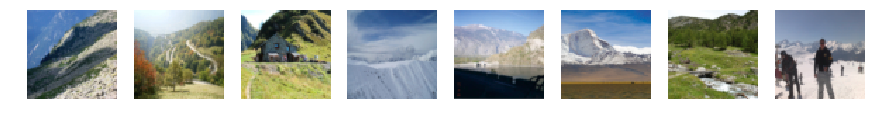

In [6]:
# show some images
plt.figure(figsize=(15,5))
X,Y = generator_woc(batch_size, train_dir, H, W).__next__()    
for i in range(8):
    plt.subplot(1,8,i+1)
    img = XY2img_woc(X[i],Y[i])
    plt.imshow(img)
    plt.axis('off')

In [7]:
# Building the neural network
import keras.backend as K
K.clear_session()
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))#TODO
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    9248      
__________

In [8]:
# compile model
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])

In [9]:
train_generator = generator_woc(batch_size, train_dir, H, W)
test_generator = generator_woc(batch_size, test_dir, H, W)
tr_size = len(glob.glob(train_dir))
ts_size = len(glob.glob(test_dir))
steps_per_epoch = tr_size// batch_size
validation_steps = ts_size // batch_size
print(tr_size,ts_size,steps_per_epoch,validation_steps)

400 200 12 6


In [10]:
t0 = time()
hist = model.fit_generator(train_generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=100,
                            validation_data=test_generator,
                            validation_steps=validation_steps,
                            verbose=0)
print('Train time: %.fm'%((time()-t0)/60))

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Train time: 3m


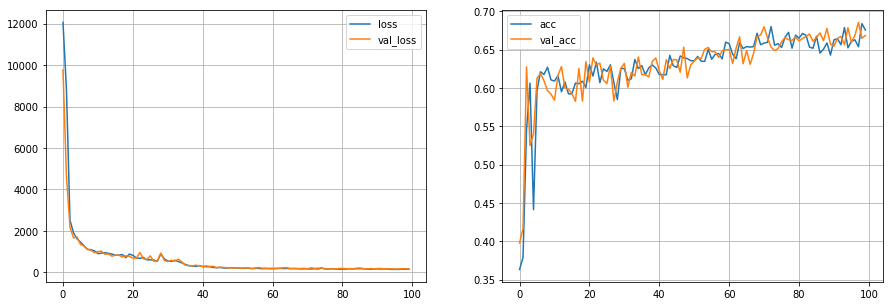

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.grid()

In [12]:
history = []
history.append(hist.history['loss'])
history.append(hist.history['val_loss'])
history.append(hist.history['acc'])
history.append(hist.history['val_acc'])
history = np.array(history)
np.savetxt(model_name+"_"+dir_name+"_history.txt", history, delimiter=",")

In [13]:
model_json = model.to_json()
with open(model_name+"_"+dir_name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name+"_"+dir_name+".h5")

In [14]:
from keras.models import model_from_json

In [15]:
json_file = open(model_name+"_"+dir_name+".json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_name+"_"+dir_name+".h5")

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


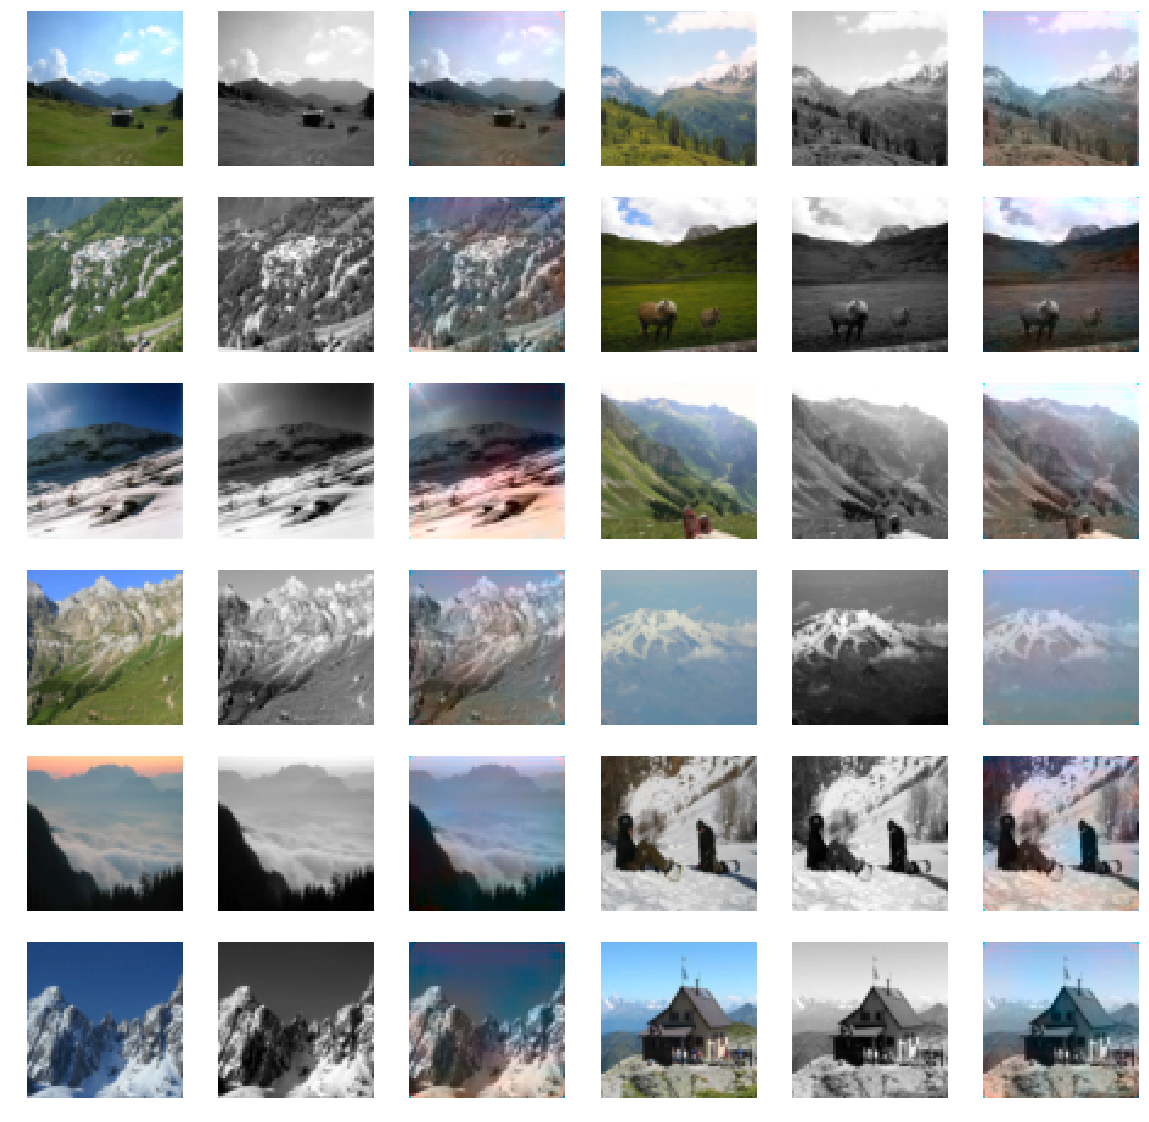

In [16]:
# result on train images
X,Y = generator_woc(batch_size, train_dir, H, W).__next__()
Yhat = loaded_model.predict(X)
j =1
plt.figure(figsize=(20,20))
for i in range(12):
    # original
    plt.subplot(6,6,j)
    j+=1
    img = XY2img_woc(X[i],Y[i])
    plt.imshow(img)
    plt.axis('OFF')
    # grayscale
    plt.subplot(6,6,j)
    j+=1
    plt.imshow(X[i,:,:,0],'gray')
    plt.axis('OFF')
    # predict
    plt.subplot(6,6,j)
    j += 1
    img = XY2img_woc(X[i],Yhat[i])
    plt.imshow(img)
    plt.axis('OFF')

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


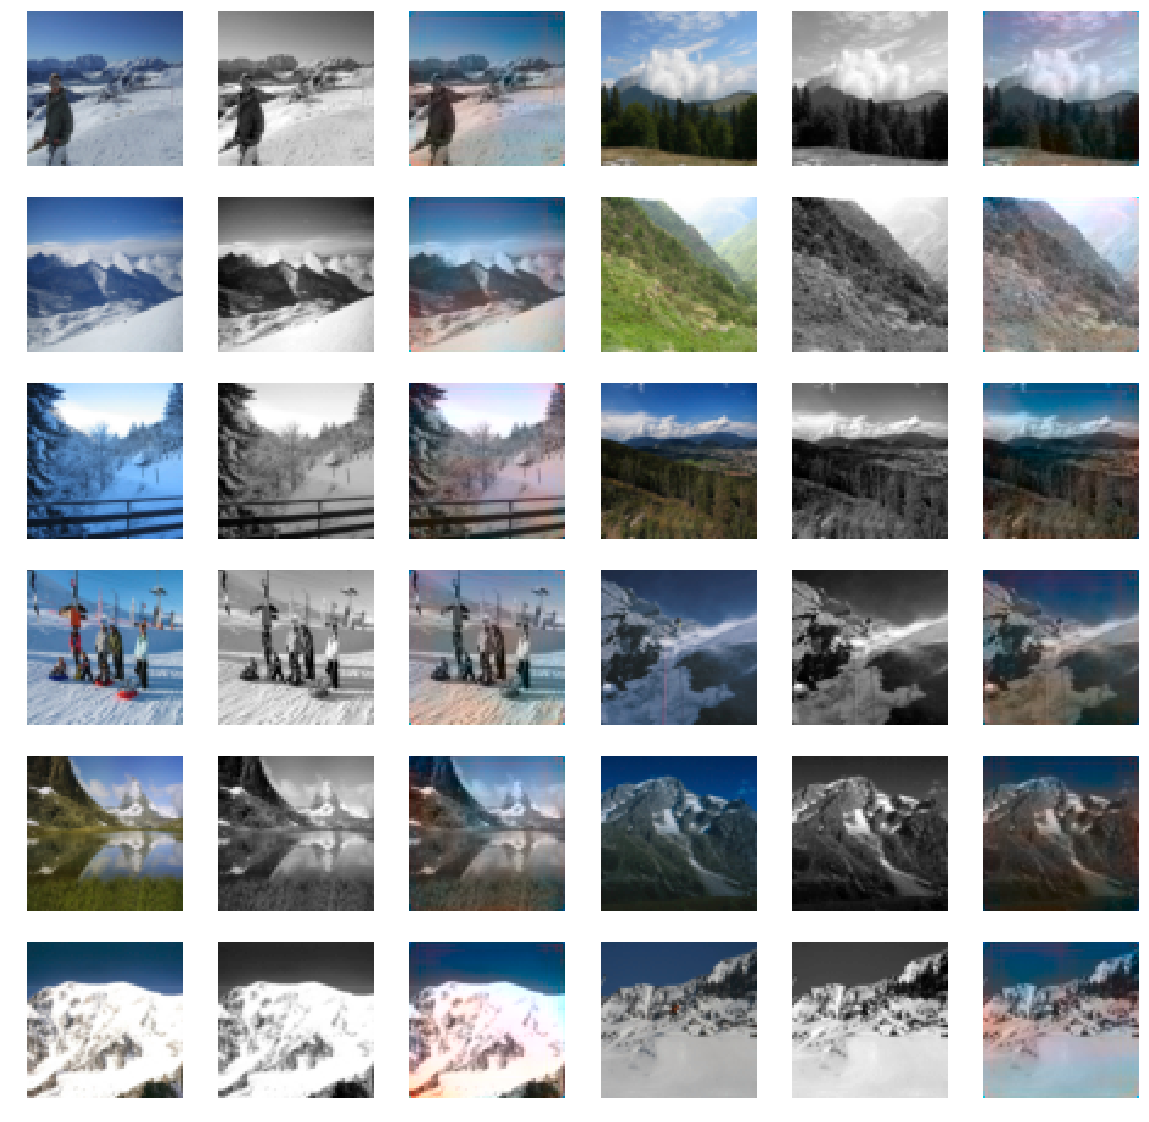

In [17]:
# result on test images
X,Y = generator_woc(batch_size, test_dir, H, W).__next__()
Yhat = loaded_model.predict(X)
j =1
plt.figure(figsize=(20,20))
for i in range(12):
    # original
    plt.subplot(6,6,j)
    j+=1
    img = XY2img_woc(X[i],Y[i])
    plt.imshow(img)
    plt.axis('OFF')
    # grayscale
    plt.subplot(6,6,j)
    j+=1
    plt.imshow(X[i,:,:,0],'gray')
    plt.axis('OFF')
    # predict
    plt.subplot(6,6,j)
    j += 1
    img = XY2img_woc(X[i],Yhat[i])
    plt.imshow(img)
    plt.axis('OFF')